# Xpand IT DS Challenge

This notebook contains the template you should use to present your code, results and conclusions. You should keep the main structure intact to make it easier to evaluate and compare in the end.

## Dataset
You can find the dataset in the data folder of the repository. The folder contains two files:
* dow_jones_index.data - dataset data
* dow_jones_index.names - dataset information and details

## Business Analysis
Here you should conduct a brief analysis of what is Dow Jones Index. You can enumerate the main topics to take into account based on the dataset provided as well as your understandings of the variables.


-----
*Add here your business analysis conclusions (max. 200 words)*

The Dow Jones Industrial Average (DJIA) is a popular representation of the performance of the United States stock market, consisting of 30 significant corporations from diverse sectors and industries. This dataset includes a comprehensive record of stock prices, open price, close price, high price, low price volumes, and other significant financial variables across time, allowing for detailed analyses and insights into market patterns, sector performance, and risk assessment.

From the analysis of the historical data, it possible to extract  patterns, correlations, and anomalies within the stock market, enabling a deeper understanding of market dynamics and investor behavior. Exploring the relationship between stock clusters and their respective sectors through clustering techniques provides valuable insights into sectoral dynamics and interdependencies within the stock market. This information could be use in the development and implementation of predictive modeling to forecast future market trends and stock prices, aiding investors in making informed decisions.

This dataset is composed by a 16 financial parameters which five variables can be estimated or predicted using the other eleven parameters. These possible target variables are:

- Next Week's Open
- Next Week's Close
- Percent Change in Next Week's Price
- Days to Next Dividend
- Percent Return Next Dividend


-----


## Data Understanding
During the data understanding phase, you should focus on understanding what each variable represents, compute statistics and visualizations. Some questions that may guide your work follow:
* Feature engineering: should new features be created from the existing ones?
* What will be your features and your label?
* Is the dataset ready for the prediction task? (ex: missing values)
* How will the data be split into train and test sets?

-----

In [192]:
#add here your imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

print("TensorFlow version:", tf.__version__)

# Check if CUDA is available
print("CUDA available:", tf.test.is_built_with_cuda())

# Check if GPU is available
print("GPU available:", tf.test.is_gpu_available())

TensorFlow version: 2.10.1
CUDA available: True
GPU available: True


In [53]:
data = pd.read_csv("dow_jones_index.data")

##### Data Analysis

In this case, I will focus on the target variable 'percent_return_next_dividend'.

In [54]:
data.columns.to_list()

['quarter',
 'stock',
 'date',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'percent_change_price',
 'percent_change_volume_over_last_wk',
 'previous_weeks_volume',
 'next_weeks_open',
 'next_weeks_close',
 'percent_change_next_weeks_price',
 'days_to_next_dividend',
 'percent_return_next_dividend']

##### Feature Engineering

In [55]:
data['date'] = pd.to_datetime(data['date'])

In [56]:
for col in ['open','high','low','close','next_weeks_open','next_weeks_close']:
    data[col] = data[col].str.replace('$', '').astype(float)

##### Outliers Analysis

In [57]:
import pandas as pd

# Make a copy of the DataFrame
datafr = pd.read_csv("dow_jones_index.data")

for col in ['open','high','low','close','next_weeks_open','next_weeks_close']:
    datafr[col] = datafr[col].str.replace('$', '').astype(float)
datafr['date'] = pd.to_datetime(datafr['date'])

df = datafr.copy()

# Group the DataFrame by 'stock'
grouped = df.groupby('stock')

# Function to identify outliers using IQR method
def identify_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (group < lower_bound) | (group > upper_bound)
    return outliers

# Group the DataFrame by 'stock'
grouped = df.groupby('stock')

# Initialize an empty list to store outlier counts
outlier_data = []

# Initialize dictionaries to store totals
total_per_parameter = {'volume': 0, 'open': 0, 'high': 0, 'low': 0, 'close': 0}
total_per_stock = {}

# Iterate over each stock and count outliers for each column
for stock, dataf in grouped:
    stock_outliers = {'stock': stock}
    total_stock = 0
    for col in ['volume', 'open', 'high', 'low', 'close']:
        outliers = identify_outliers(dataf[col])
        count_outliers = outliers.sum()
        stock_outliers[col] = count_outliers
        total_per_parameter[col] += count_outliers
        total_stock += count_outliers
    stock_outliers['total'] = total_stock
    total_per_stock[stock] = total_stock
    outlier_data.append(stock_outliers)

# Convert the list of dictionaries to a DataFrame
outliers_df = pd.DataFrame(outlier_data)

outliers_df= outliers_df._append({'stock':'Total','volume': outliers_df['volume'].sum(),'open':outliers_df['open'].sum(), 'high':outliers_df['high'].sum(), 'low':outliers_df['low'].sum(), 'close':outliers_df['close'].sum(),'total':outliers_df['total'].sum()}, ignore_index=True)
# Display the DataFrame
outliers_df.head(31)

,stock,volume,open,high,low,close,total
0,AA,4,0,0,0,0,4
1,AXP,0,0,0,0,0,0
2,BA,0,2,3,2,1,8
3,BAC,1,0,0,0,0,1
4,CAT,0,0,0,0,0,0
5,CSCO,1,1,2,0,1,5
6,CVX,0,0,0,0,0,0
7,DD,1,0,0,0,0,1
8,DIS,1,0,0,0,0,1
9,GE,3,0,0,0,0,3


##### In a more deep analysis, I would remove the outliers, but in this case i will only use for modelling the stocks with no outliers found.

In [251]:
outliers_df[outliers_df['total'] == 0]

,stock,volume,open,high,low,close,total
1,AXP,0,0,0,0,0,0
4,CAT,0,0,0,0,0,0
6,CVX,0,0,0,0,0,0
14,JNJ,0,0,0,0,0,0
16,KO,0,0,0,0,0,0


##### Analysis of correlations between target variables and predictor variables.

In [252]:
def calculate_correlations(data,x,y):
    # Pivot the DataFrame to have separate columns for percent change price for each company
    pivot_data = data.pivot(index='date', columns=x, values=y)
    
    # Compute correlations between all pairs of companies
    correlations = pivot_data.corr(method='pearson')
    
    # Filter correlations greater than 0.20 or less than -0.20
    filtered_correlations = correlations[(correlations > 0.40) | (correlations < -0.40)]
    
    return filtered_correlations, pivot_data

In [253]:
def correlation_target(data,var,columns):
    columns += ['percent_change_volume_over_last_wk','previous_weeks_volume',var]
    df =data[columns]
    correlation_matrix = df.corr()

    # Extract correlation of percent_return_next_dividend with other variables
    correlation_with_target = correlation_matrix[var].drop(var)
    return correlation_with_target

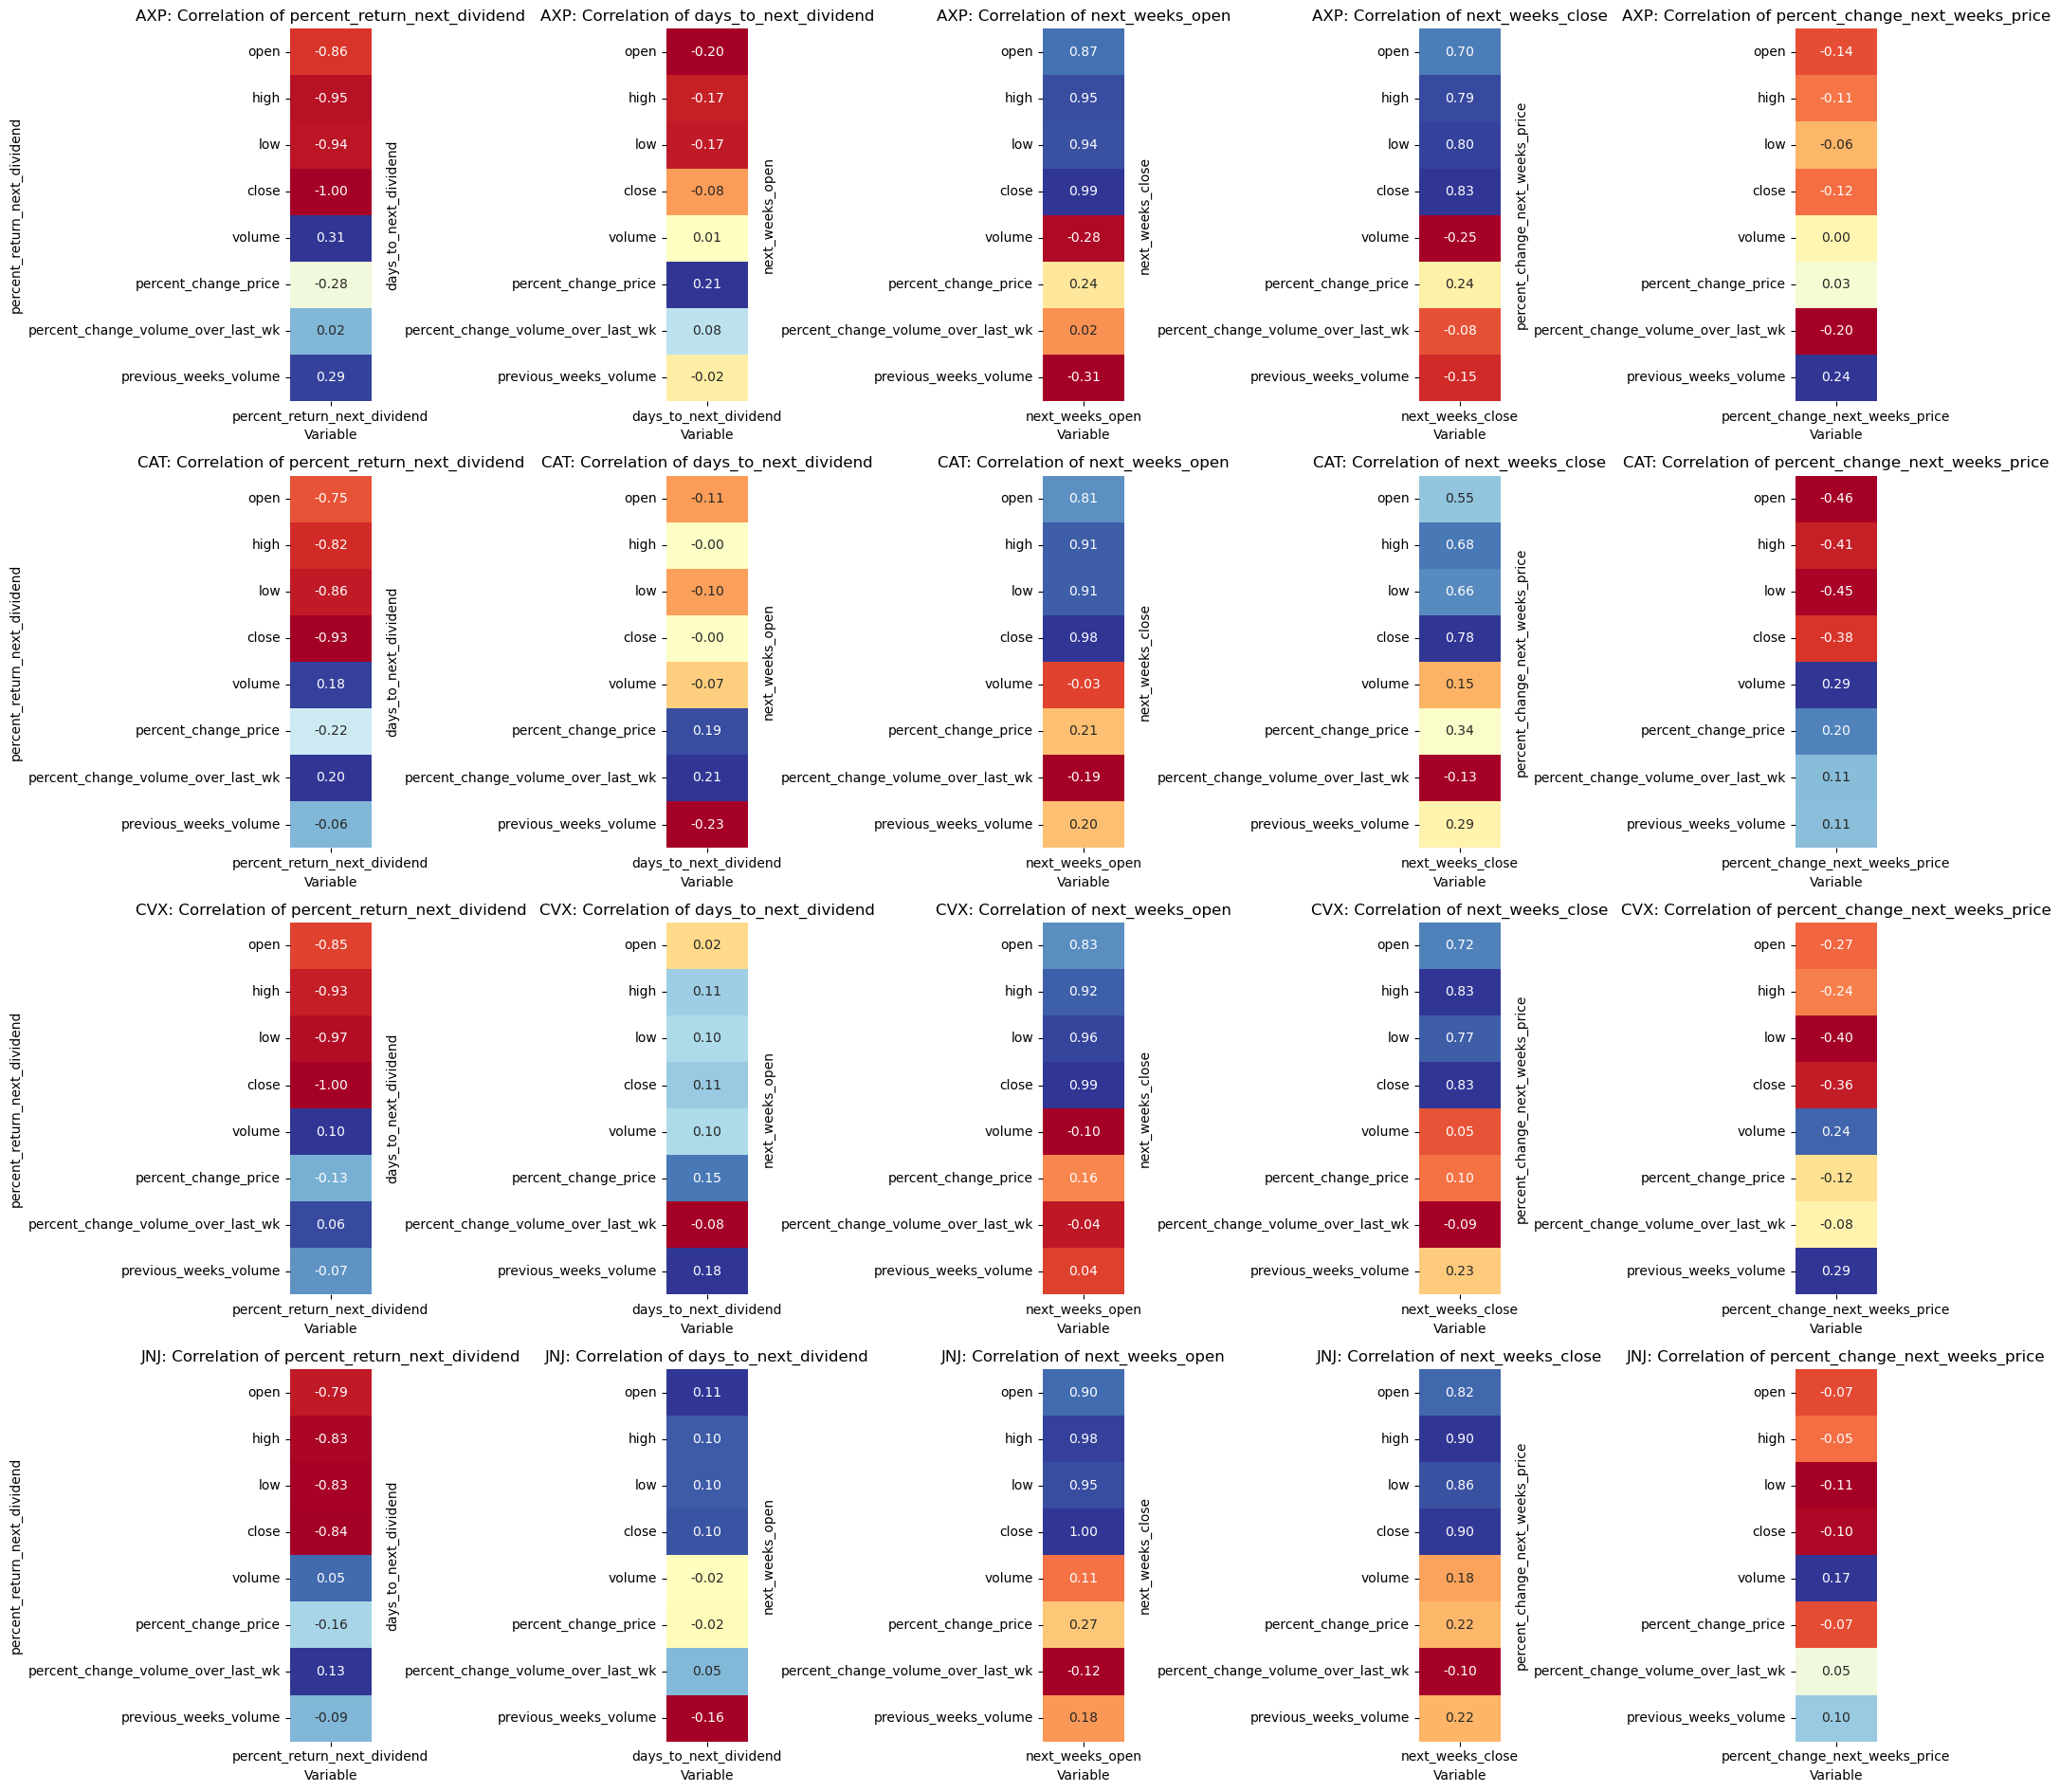

In [255]:
# Variables to analyze
variables = ['percent_return_next_dividend', 'days_to_next_dividend', 'next_weeks_open', 'next_weeks_close', 'percent_change_next_weeks_price']

# Create a figure with subplots
fig, axes = plt.subplots(4, len(variables), figsize=(20, 19))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
# Iterate over stocks
sample_data = data.dropna()
for j, stock in enumerate(['AXP', 'CAT','CVX','JNJ']):
    # Filter data for the current stock
    columns = ['open','high','low','close','volume','percent_change_price']
    stock_data = sample_data[sample_data['stock'] == stock]
    
    # Iterate over variables and plot heatmaps
    for i, var in enumerate(variables):
        # Extract correlation
        correlation = correlation_target(stock_data, var,columns=columns.copy())
        
        # Plot heatmap
        sns.heatmap(correlation.to_frame(), cmap='RdYlBu', annot=True, fmt=".2f", cbar=False, ax=axes[j][i])
        axes[j][i].set_title(f'{stock}: Correlation of {var}')
        axes[j][i].set_xlabel('Variable')
        axes[j][i].set_ylabel(var)

plt.tight_layout()
plt.show()

- The best predictors function will be used in modelling phase to determine the best correlated predictors to the chosen target variable regarding the chosen stock dataset

In [257]:
def best_predictors(data,stock):
    # Variables to analyze
    variables = ['percent_return_next_dividend', 'days_to_next_dividend', 'next_weeks_open', 'next_weeks_close', 'percent_change_next_weeks_price']
    
    # Create a figure with subplots
    _, axes = plt.subplots(1, len(variables), figsize=(20, 9))

    # Iterate over stocks
    sample_data = data.dropna()

    # Filter data for the current stock
    columns = ['open','high','low','close','volume','percent_change_price']
    stock_data = sample_data[sample_data['stock'] == stock]
        
    # Iterate over variables and plot heatmaps
    for i, var in enumerate(variables):
        # Extract correlation
        correlation = correlation_target(stock_data, var,columns=columns.copy())
            
        # Plot heatmap
        sns.heatmap(correlation.to_frame(), cmap='RdYlBu', annot=True, fmt=".2f", cbar=False, ax=axes[i])
        axes[i].set_title(f'{stock}: Correlation of {var}')
        axes[i].set_xlabel('Variable')
        axes[i].set_ylabel(var)

    plt.tight_layout()
    plt.show()


##### Nulls analysis and removal

In [62]:
data.isnull().sum()


quarter                                0
stock                                  0
date                                   0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
next_weeks_close                       0
percent_change_next_weeks_price        0
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64

In [63]:
data[data['percent_change_volume_over_last_wk'].isnull()]['date'].unique()

<DatetimeArray>
['2011-01-07 00:00:00']
Length: 1, dtype: datetime64[ns]

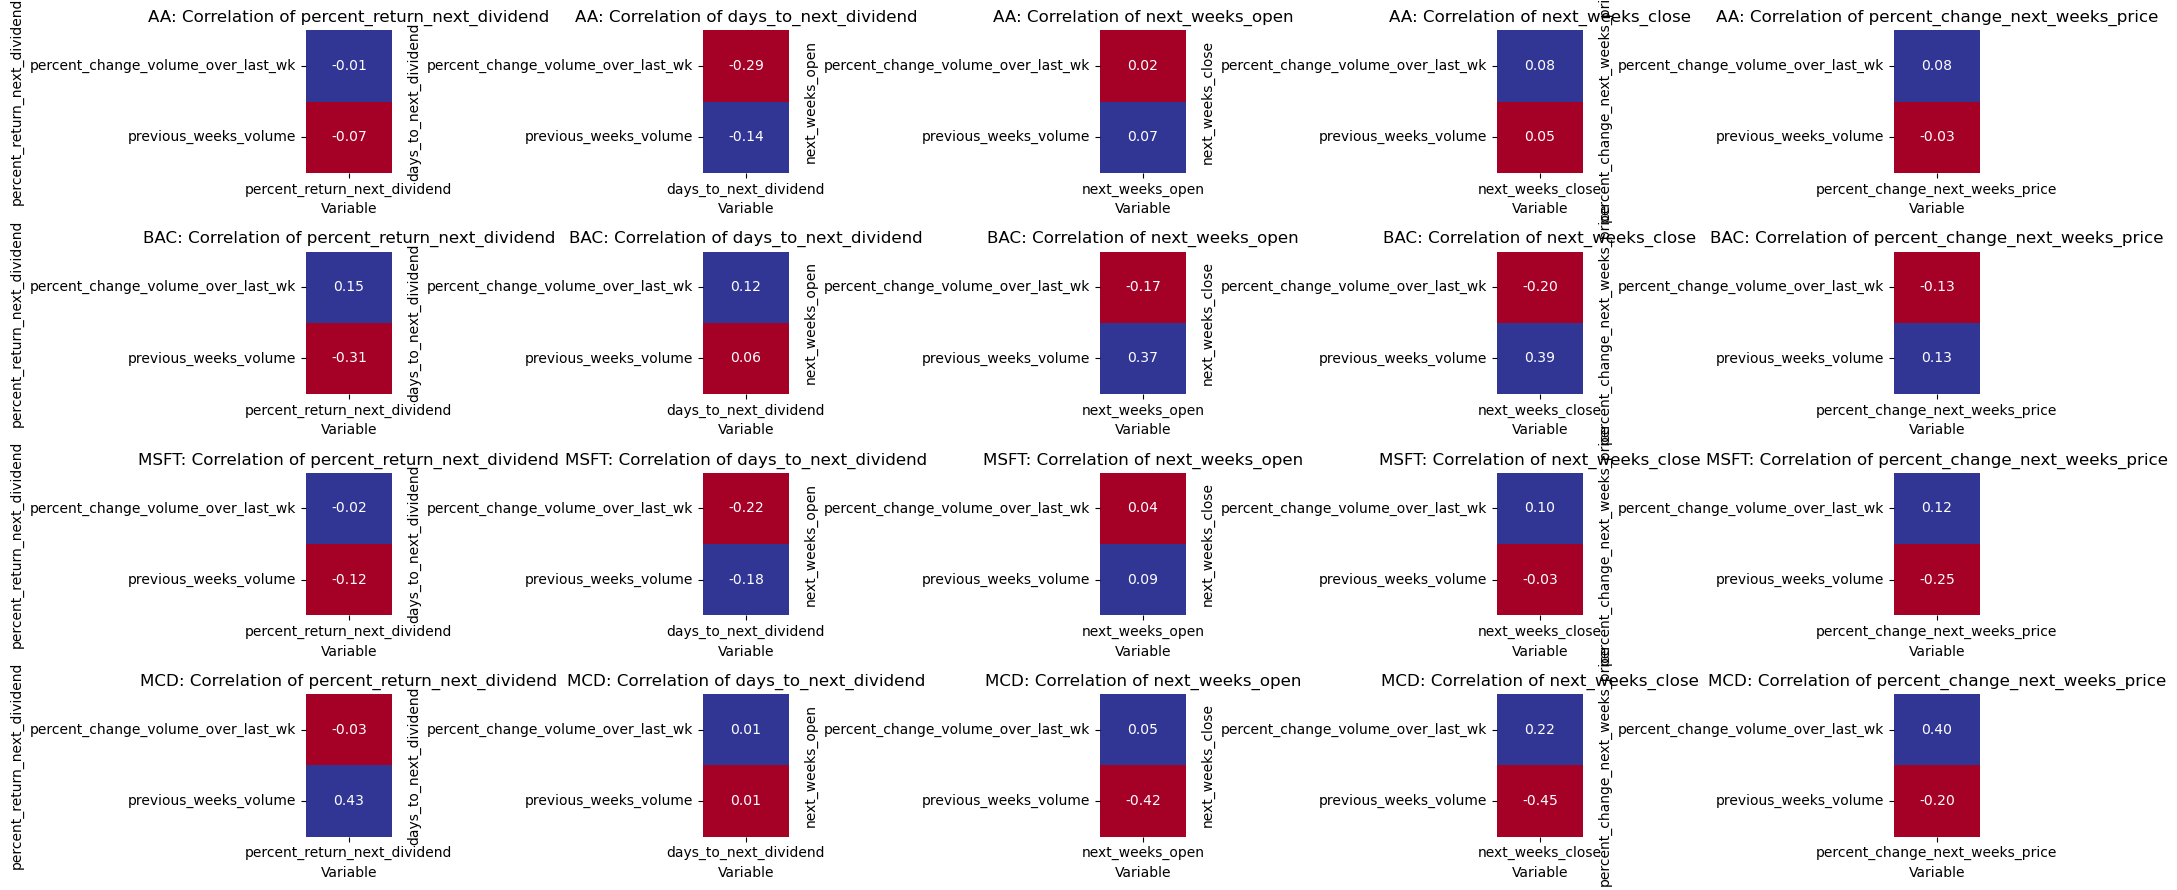

In [64]:
# Variables to analyze
variables = ['percent_return_next_dividend', 'days_to_next_dividend', 'next_weeks_open', 'next_weeks_close', 'percent_change_next_weeks_price']

# Create a figure with subplots
fig, axes = plt.subplots(4, len(variables), figsize=(20, 9))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
# Iterate over stocks
columns = ['open','high','low','close','volume','percent_change_price']
sample_data = data.drop(columns = columns).dropna()
for j, stock in enumerate(['AA', 'BAC','MSFT','MCD']):
    # Filter data for the current stock
    columns = ['open','high','low','close','volume','percent_change_price']
    stock_data = sample_data[sample_data['stock'] == stock]
    
    # Iterate over variables and plot heatmaps
    for i, var in enumerate(variables):
        # Extract correlation
        correlation = correlation_target(stock_data, var,columns=[])
        
        # Plot heatmap
        sns.heatmap(correlation.to_frame(), cmap='RdYlBu', annot=True, fmt=".2f", cbar=False, ax=axes[j][i])
        axes[j][i].set_title(f'{stock}: Correlation of {var}')
        axes[j][i].set_xlabel('Variable')
        axes[j][i].set_ylabel(var)

plt.tight_layout()
plt.show()




- In this case, since in some cases the variables percent_change_volume_over_last_wk and previous_weeks_volume have a correlation greater than 0.20, I decided to keep these two variables and remove the first day for each stock dataset.

In [258]:
data = data.dropna()

##### Analysis of the correlations between different stocks

In [260]:
def calculate_correlations(data,x,y):
    # Pivot the DataFrame to have separate columns for percent change price for each company
    pivot_data = data.pivot(index='date', columns=x, values=y)
    
    # Compute correlations between all pairs of companies
    correlations = pivot_data.corr(method='pearson')
    
    # Filter correlations greater than 0.20 or less than -0.20
    filtered_correlations = correlations[(correlations > 0.40) | (correlations < -0.40)]
    
    return filtered_correlations

##### Correlation between different stocks (based on percent_return_next_dividend)

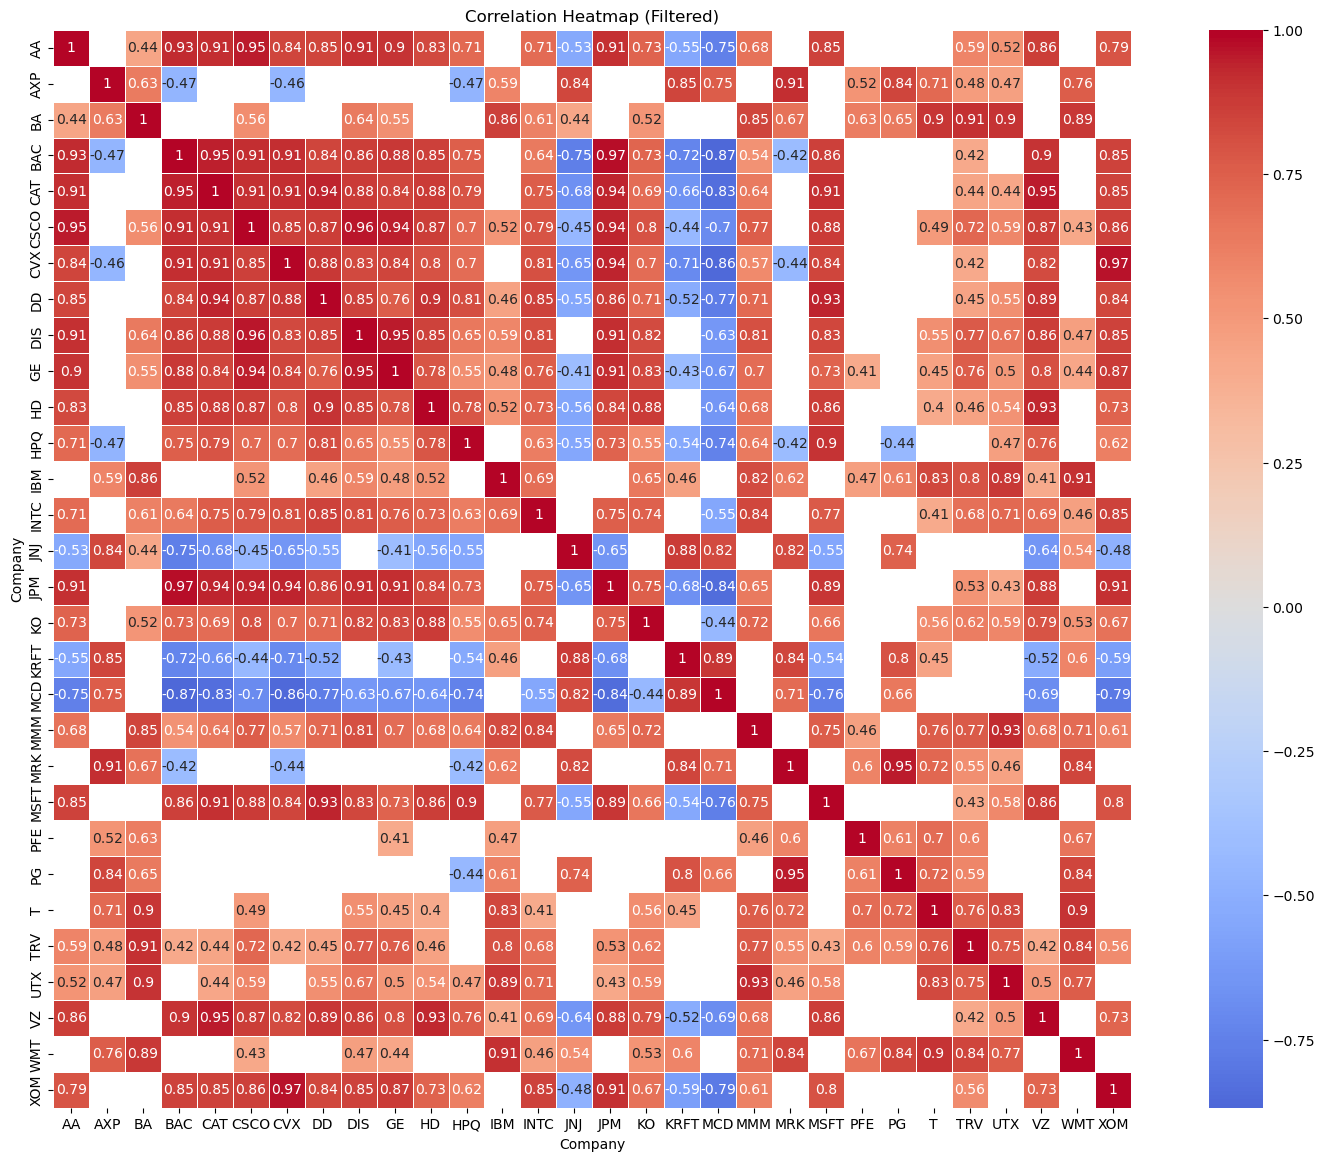

In [261]:
# Call the function with your DataFrame
sample = data[data['quarter'] == 2]

correlation_results_stocks = calculate_correlations(sample,'stock','percent_return_next_dividend')

# Create a heatmap
plt.figure(figsize=(20, 14))

sns.heatmap(correlation_results_stocks, cmap='coolwarm', annot=True, center=0,square=True, linewidths=0.5)
plt.title('Correlation Heatmap (Filtered)')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


- The get_top_correlated_stocks function will be used during the modeling phase to identify the stocks that are most correlated with the chosen target stock regarding the choosen target variable.

In [262]:
def get_top_correlated_stocks(df, target_stocks, top_n=3):
    
    # Filter out the target_sector row and sort the correlations
    correlations = df.loc[target_stocks].dropna().sort_values(ascending=False)
    
    # Get the top n correlated sectors excluding the target sector itself
    top_correlated_sectors = correlations.index[1:top_n+1]
    
    return top_correlated_sectors

In [263]:
get_top_correlated_stocks(correlation_results_stocks,'CAT',5)

Index(['VZ', 'BAC', 'DD', 'JPM', 'AA'], dtype='object', name='stock')

##### Analysis of the relationship between different Stocks based on the variable 'percent_change_next_weeks_price'

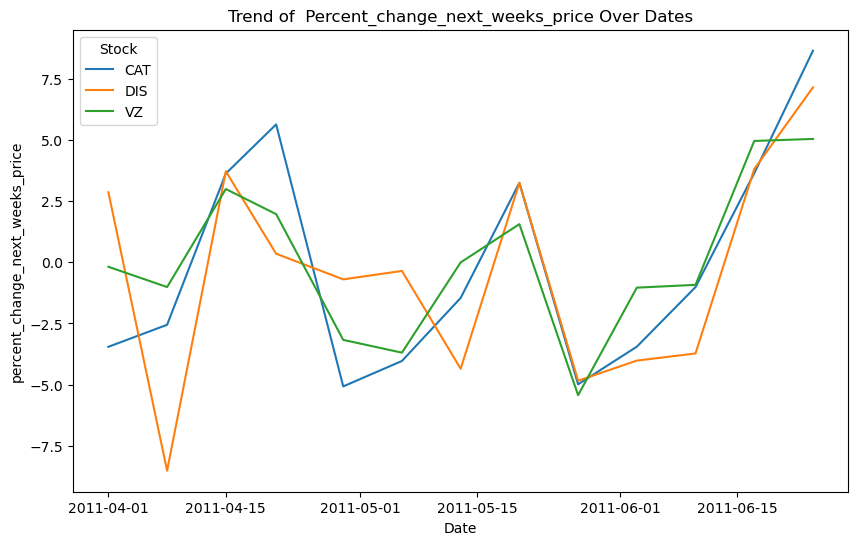

In [270]:


# Plot the trend of stock prices over dates
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='percent_change_next_weeks_price', data=sample[sample['stock'] == 'CAT'], label='CAT')
sns.lineplot(x='date', y='percent_change_next_weeks_price', data=sample[sample['stock'] == 'AA'], label='DIS')
sns.lineplot(x='date', y='percent_change_next_weeks_price', data=sample[sample['stock'] == 'DD'], label='VZ')
plt.title('Trend of  Percent_change_next_weeks_price Over Dates')
plt.xlabel('Date')
plt.ylabel('percent_change_next_weeks_price')
plt.legend(title='Stock')
plt.show()


- I decided to verify if there was a relation between the stock from the same sector. The function below was based on Yahoo Finance Sectors Information

##### Analysis of the relation between different sectors based on variable 'percent_change_next_weeks_price

In [271]:
def add_sector(r):
    if r['stock'] == 'AA' or r['stock'] == 'DD':
        return 'basic materials'
    if r['stock'] == 'T' or r['stock'] == 'VZ' or r['stock'] == 'DIS':
        return 'communication services'
    if r['stock'] == 'MCD' or r['stock'] == 'HD':
        return 'consumer cyclical'
    if r['stock'] == 'KO' or r['stock'] == 'KRFT' or r['stock'] == 'PG'or r['stock'] == 'WMT':
        return 'consumer defensive'
    if r['stock'] == 'CVX' or r['stock'] == 'XOM':
        return 'energy'
    if r['stock'] == 'AXP' or r['stock'] == 'BAC' or r['stock'] == 'JPM' or r['stock'] == 'TRV':
        return 'financial'
    if r['stock'] == 'JNJ' or r['stock'] == 'MRK' or r['stock'] == 'PFE':
        return 'healthcare'
    if r['stock'] == 'MMM' or r['stock'] == 'BA' or r['stock'] == 'CAT'or r['stock'] == 'GE'or r['stock'] == 'UTX':
        return 'industrial'
    if r['stock'] == 'CSCO' or r['stock'] == 'HPQ' or r['stock'] == 'IBM' or r['stock'] == 'INTC' or r['stock'] == 'MSFT':
        return 'technology'
    
data['sector'] = data.apply(add_sector,axis=1)

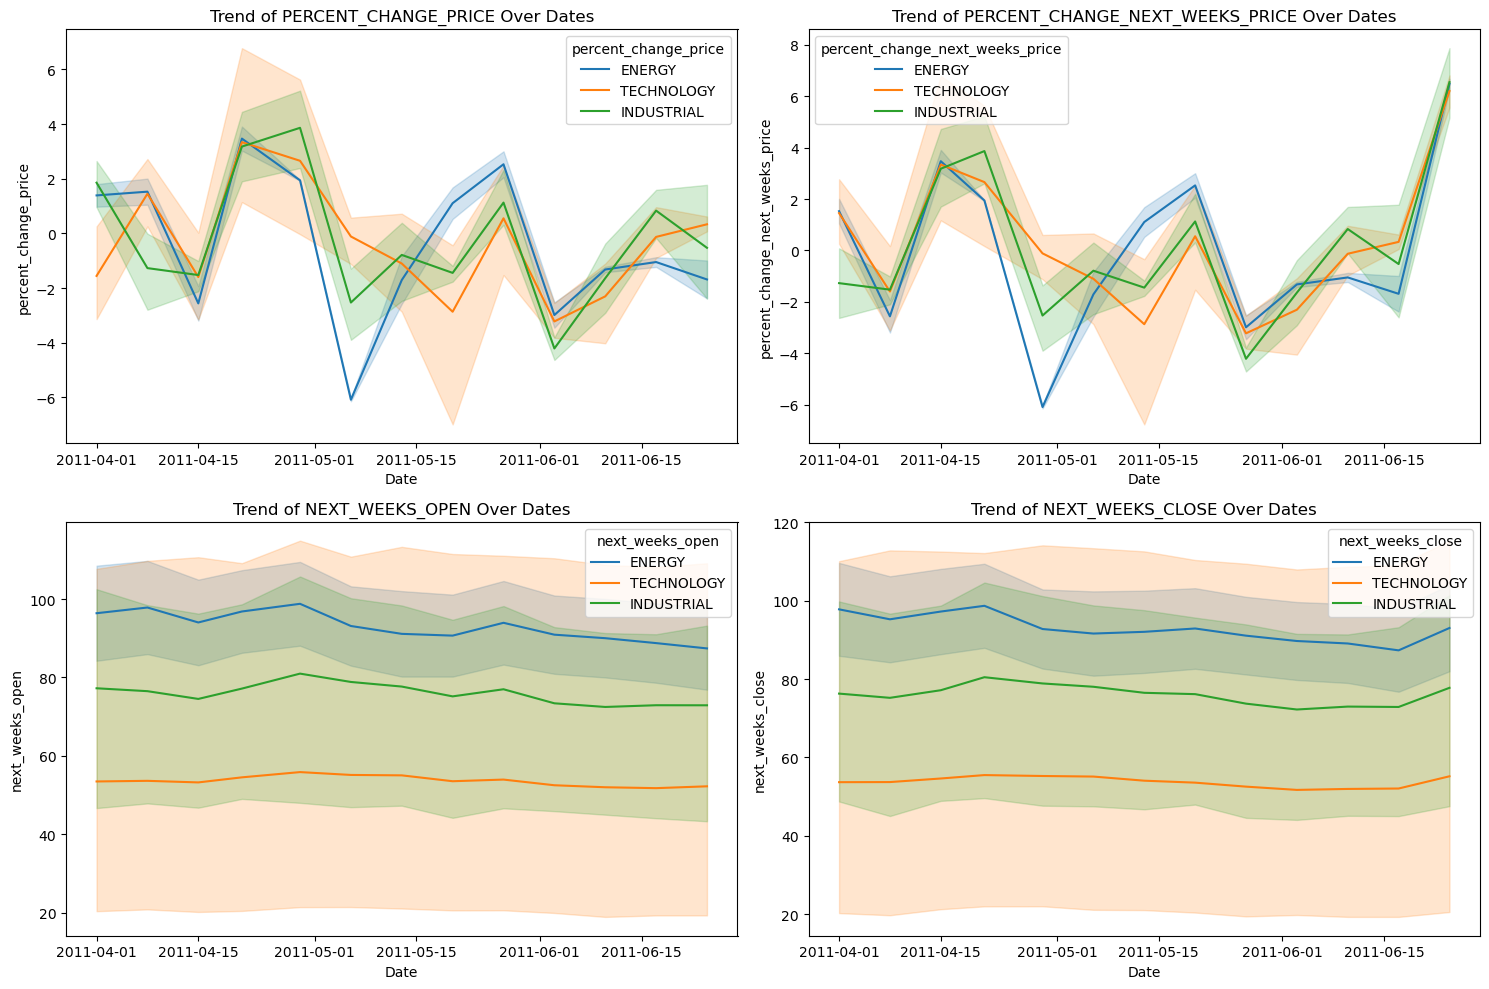

In [272]:
# Sample data
sample = data[data['quarter'] == 2]

# Define the columns to analyze
columns_to_analyze = ['percent_change_price', 'percent_change_next_weeks_price', 'next_weeks_open', 'next_weeks_close']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot each column in a subplot
for i, column_to_analyse in enumerate(columns_to_analyze):
    row_index = i // 2
    col_index = i % 2
    
    ax = axes[row_index, col_index]
    
    sns.lineplot(x='date', y=column_to_analyse, data=sample[sample['sector'] == 'energy'], label='energy'.upper(), ax=ax)
    sns.lineplot(x='date', y=column_to_analyse, data=sample[sample['sector'] == 'technology'], label='technology'.upper(), ax=ax)
    sns.lineplot(x='date', y=column_to_analyse, data=sample[sample['sector'] == 'industrial'], label='industrial'.upper(), ax=ax)
    
    ax.set_title(f'Trend of {column_to_analyse.upper()} Over Dates')
    ax.set_xlabel('Date')
    ax.set_ylabel(column_to_analyse)
    ax.legend(title=column_to_analyse)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [275]:
def create_sectors_df(df,quarter):
    new_df = pd.DataFrame()
    df = df[df['quarter'] == quarter]
    for s in df['sector'].unique():
        sector_df = df[df['sector'] == s]
        for d in sector_df['date'].unique():
            days_df = sector_df[sector_df['date'] == d]
            new_row = {
                'sector': s,
                'date': d,
                'percent_change_price': days_df['percent_change_price'].mean(),
                'percent_change_next_weeks_price': days_df['percent_change_next_weeks_price'].mean(),
                'next_weeks_open': days_df['next_weeks_open'].mean(),
                'next_weeks_close': days_df['next_weeks_close'].mean()
            }
            new_df = new_df._append(new_row, ignore_index=True)
    return new_df



In [276]:
def get_top_correlated_sectors(df, target_sector, top_n=3):
    
    # Filter out the target_sector row and sort the correlations
    correlations = df.loc[target_sector].dropna().sort_values(ascending=False)
    
    # Get the top n correlated sectors excluding the target sector itself
    top_correlated_sectors = correlations.index[1:top_n+1]
    
    return top_correlated_sectors

##### Analysis of the correlations between different sectors based on the variable 'percent_change_next_weeks_price

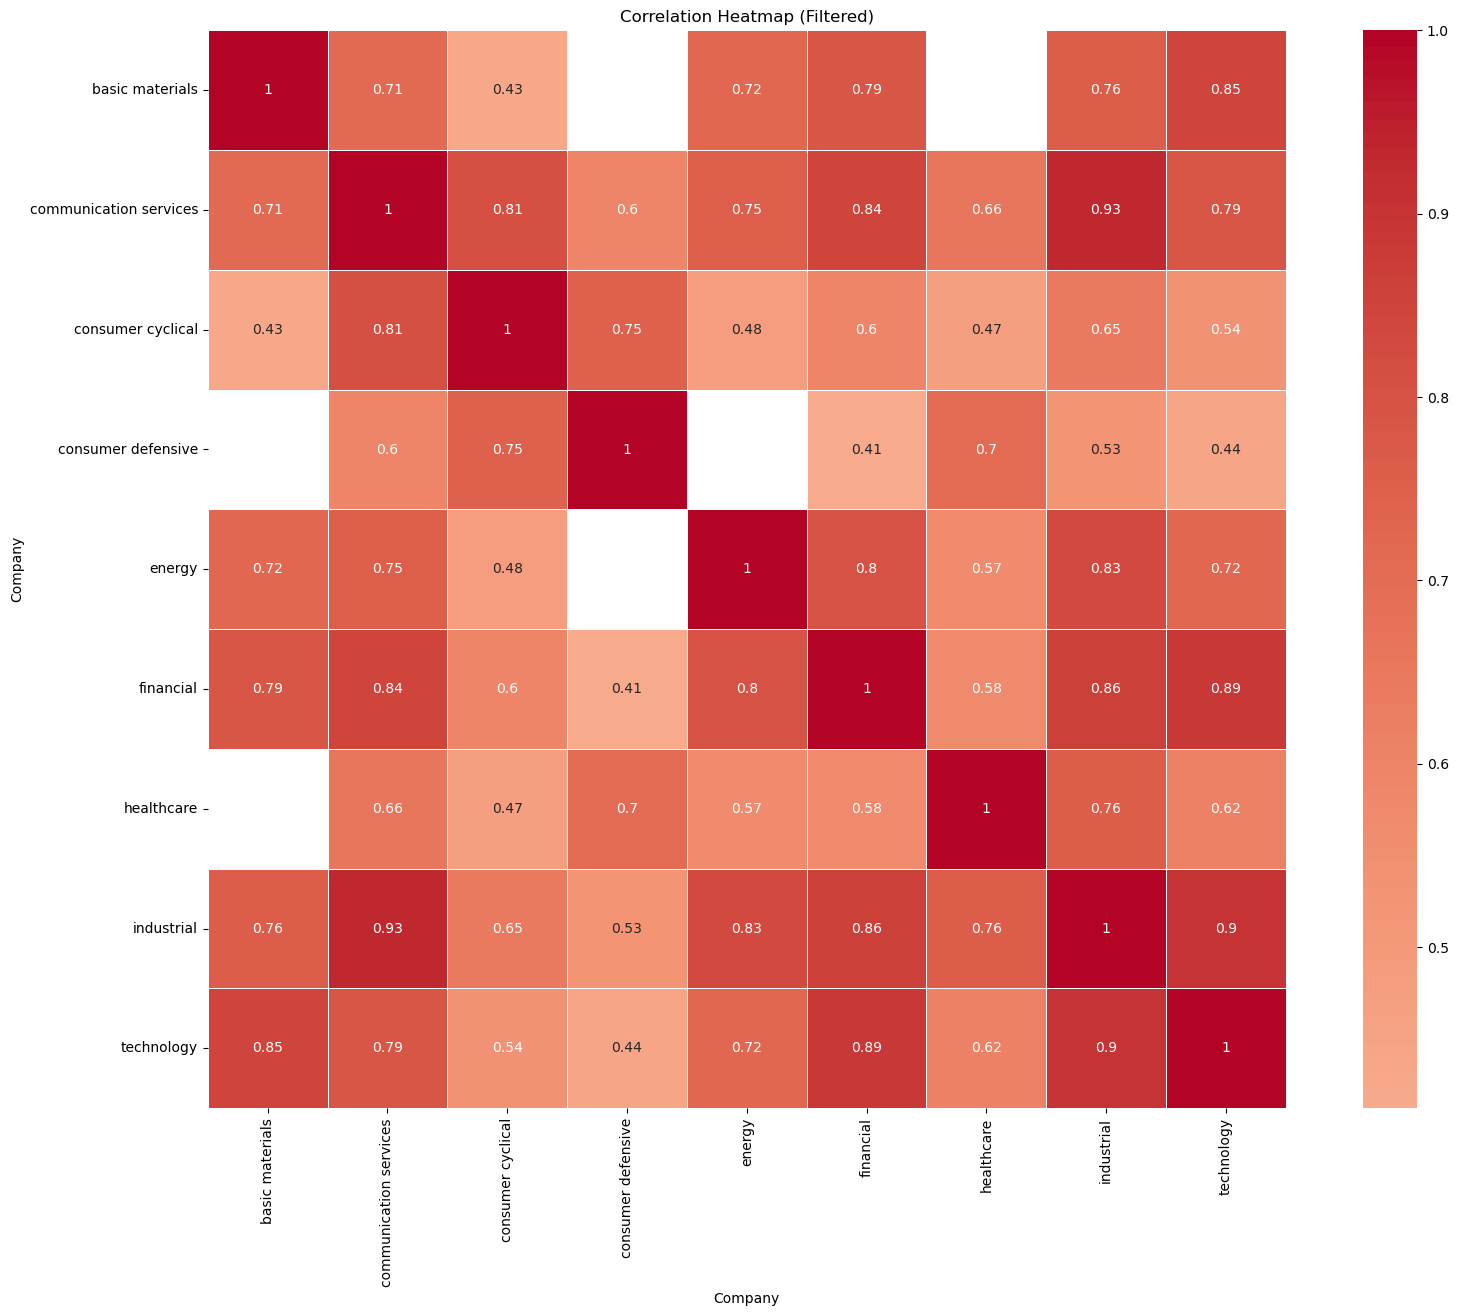

In [278]:
sectors_df = create_sectors_df(data,2)
correlation_results = calculate_correlations(sectors_df,'sector','percent_change_next_weeks_price')
# Create a heatmap
plt.figure(figsize=(20, 14))
sns.heatmap(correlation_results, cmap='coolwarm', annot=True, center=0,square=True, linewidths=0.5)
plt.title('Correlation Heatmap (Filtered)')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

In [279]:
get_top_correlated_sectors(correlation_results,'technology')

Index(['industrial', 'financial', 'basic materials'], dtype='object', name='sector')

- Then, I decided to apply clustering to the different stocks to verify if there was any relationship between the stocks within each cluster and the sector they belong to

##### Analysis of the relationship between the stocks within each cluster and the sector they belong to

In [280]:
def create_stocks_df(df):
    df.dropna(inplace=True)
    new_df= pd.DataFrame()
    for s in df['stock'].unique():
        stock_df = df[df['stock'] == s]
        new_row = {'stock': s,
                   'open': stock_df['open'].mean(),
                   'low': stock_df['low'].mean(),
                   'high': stock_df['high'].mean(),
                   'close': stock_df['close'].mean(),
                   'volume': stock_df['volume'].mean(),
                   'next_weeks_close': stock_df['next_weeks_close'].mean(),
                   'percent_return_next_dividend': stock_df['percent_return_next_dividend'].mean(),

        }
        new_df = new_df._append(new_row, ignore_index=True)
    return new_df

In [281]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


df= create_stocks_df(data)


# Handle missing values
df.fillna(0, inplace=True)  # Filling missing values with 0, you can choose a different strategy

# Select relevant features
X = df[['open','low','high','close','percent_return_next_dividend','volume']]

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



##### I used two different techniques to make sure the number of clusters was the correct one: Elbow Method and the Silhouette_score technique

c:\Users\josep\miniconda3\envs\TF\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\josep\miniconda3\envs\TF\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\josep\miniconda3\envs\TF\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\josep\miniconda3\envs\TF\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is k

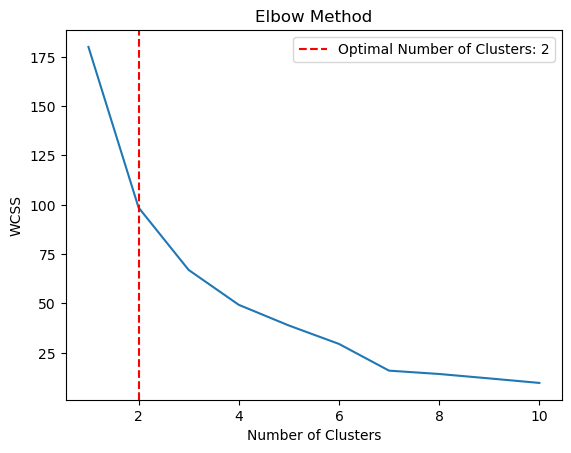

Optimal Number of Clusters: 2


In [81]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Find the optimal number of clusters
optimal_num_clusters = None
for i in range(1, len(wcss) - 1):
    if (wcss[i] - wcss[i + 1]) / (wcss[i - 1] - wcss[i]) > 0.1:
        optimal_num_clusters = i + 1
        break

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.axvline(x=optimal_num_clusters, color='r', linestyle='--', label=f'Optimal Number of Clusters: {optimal_num_clusters}')
plt.legend()
plt.show()

print("Optimal Number of Clusters:", optimal_num_clusters)


c:\Users\josep\miniconda3\envs\TF\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\josep\miniconda3\envs\TF\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\josep\miniconda3\envs\TF\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\josep\miniconda3\envs\TF\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is k

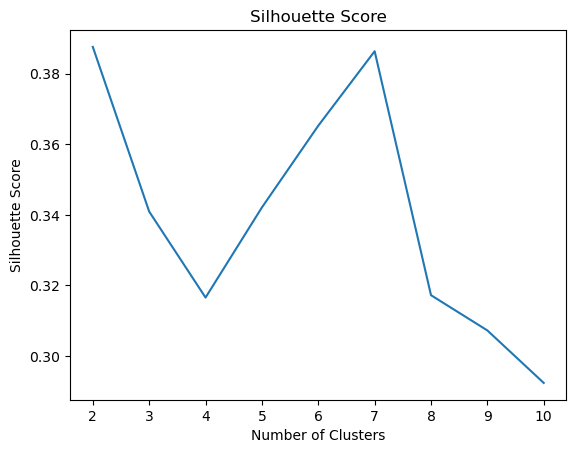

In [82]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [83]:
# Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)
cluster_groups = df.groupby('Cluster')['stock'].unique()

for cluster, stocks in cluster_groups.items():
    print(f"Cluster {cluster}: {', '.join(stocks)}")

Cluster 0: BA, CAT, CVX, DD, IBM, JNJ, KO, MCD, MMM, PG, TRV, UTX, WMT, XOM
Cluster 1: AA, AXP, BAC, CSCO, DIS, GE, HD, HPQ, INTC, JPM, KRFT, MRK, MSFT, PFE, T, VZ


c:\Users\josep\miniconda3\envs\TF\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


-----
*Add here your data understanding findings and conclusions (max. 200 words)*

In this data analysis, the following procedures were conducted:

Feature Engineering: Date and price columns (Open, Low, High, etc.) were formatted from string to datetime and float.

Outliers Analysis: 86 outliers values were found(0.7% of all values). Most outliers were identified in the volume column.

Nulls Analysis and Removal: Two variables, 'percent_change_volume_over_last_week' and 'previous_weeks_volume', contained null values. The impact of these null values on forecasting results was assessed. As the percentage of nulls in each column did not exceed 40%, rows with null values were removed.

Correlation Analysis: Relationships between target and predictor variables were explored. For example, the 'CAT' stock's percent_return_next_dividend was best predicted by the close_price parameter.

Inter-stock Correlation: Stocks most correlated with 'CAT' based on 'percent_change_next_weeks_price' were identified as 'VZ', 'BAC', 'DD', 'JPM', 'AA'.

Sector-Stock Relationship: Analysis revealed connection between the stock setor and the cluster were the stock belong to. For example, many tech sector stocks belonged to the same cluster (e.g., CSCO, HPQ, INTC, MSFT - > Cluster 2).
-----

## Modelling
In this phase, your main goal is to develop and describe your approach to the solution of the problem. Some guidelines to help you:
* What metrics will you use to evaluate your solutions?
* What are some algorithms that can lead to good results? And why?
* Describe in detail your thought process during the development of your solution.
* Present your results.


-----


#### Analysis of Time Series Prediction using only one stock data.

In [292]:
# Firstly, we select the stock, in this case, it will be CAT
stock = 'CAT'


##### Feature Selection for the percent_return_next_dividend parameter

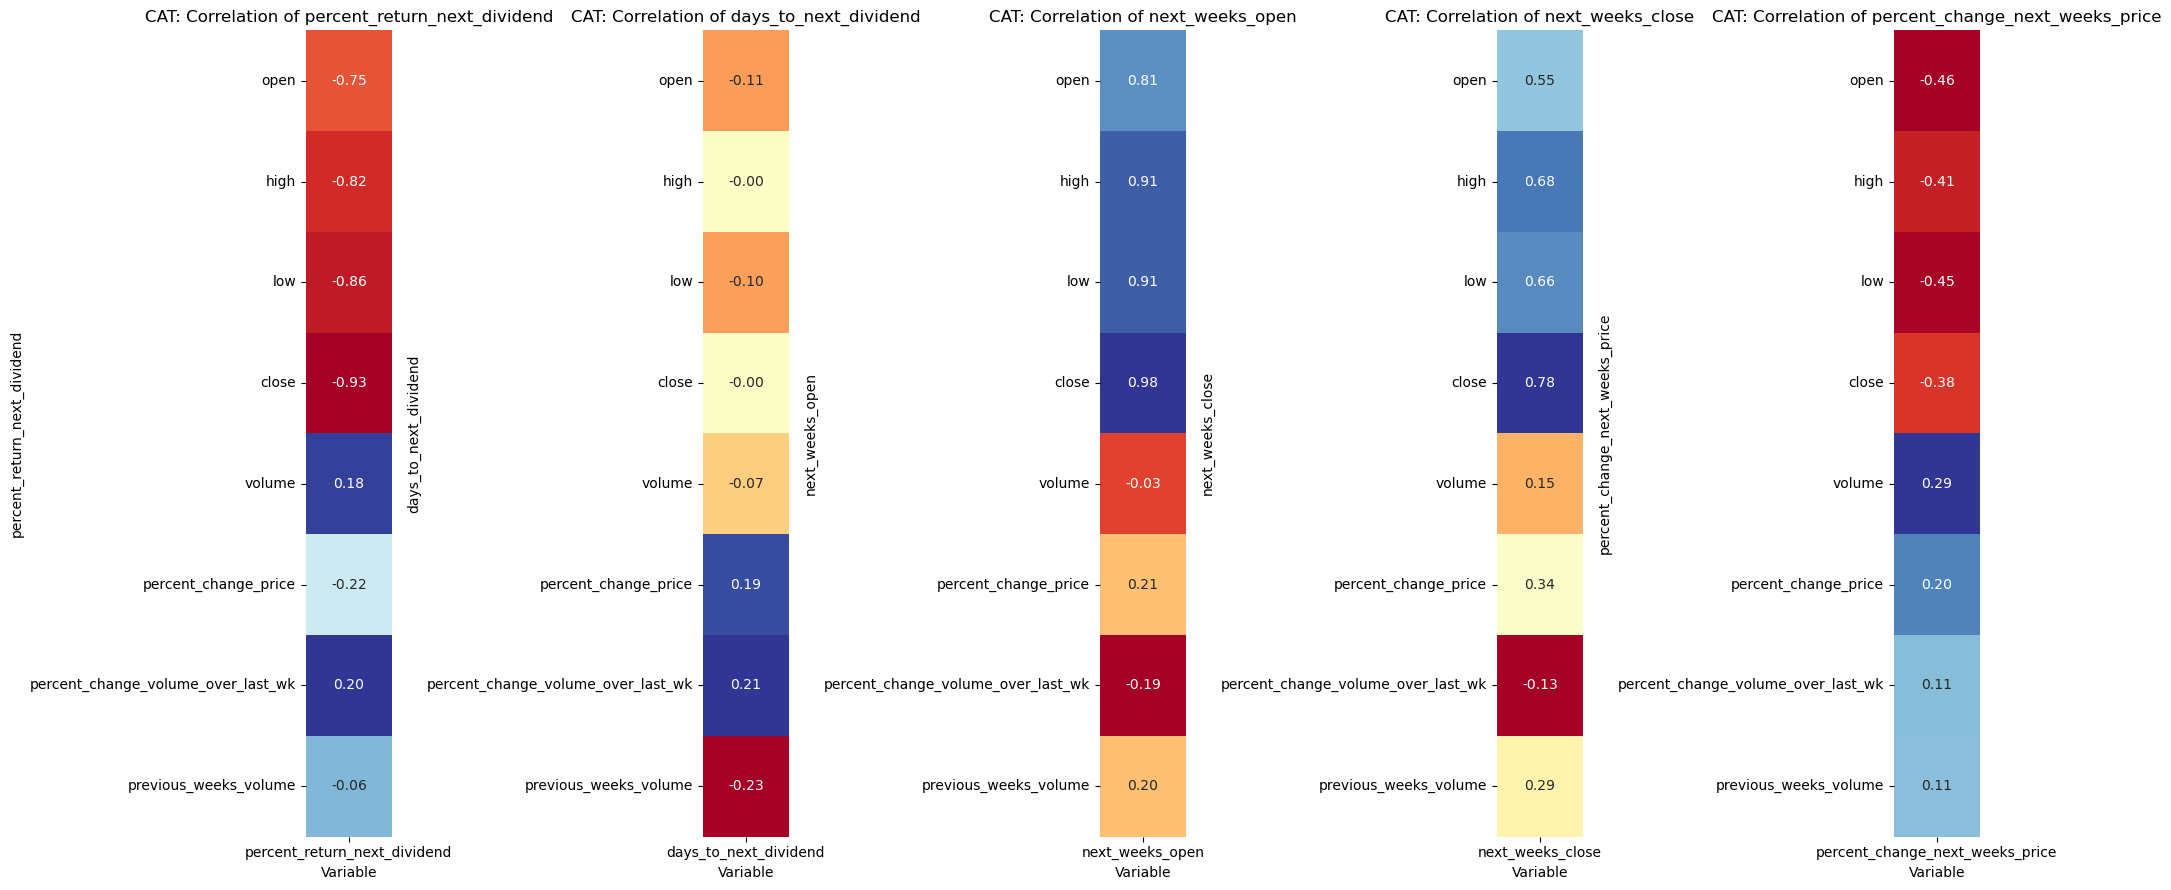

In [293]:
best_predictors(data,stock=stock)

In [321]:
choosen_features =['close','volume','percent_change_price','percent_change_volume_over_last_wk','previous_weeks_volume']

In [322]:
analysed_stock_data = data[data['stock']==stock][['date']+choosen_features+['percent_return_next_dividend']]

In [310]:
df = pd.DataFrame(analysed_stock_data)

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set date column as index
df.set_index('date', inplace=True)

# Choose the date to split the data
split_date = pd.to_datetime('2011-05-01')

# Split the data into train and test sets
train = df[df.index < split_date]
test = df[df.index >= split_date]

# Scale the numerical features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Split into input (X) and output (Y) variables
X_train = train_scaled[:, :-1]  # Features
y_train = train_scaled[:, -1]   # Target variable
X_test = test_scaled[:, :-1]    # Features
y_test = test_scaled[:, -1]     # Target variable


print(len(X_train),len(y_train),len(X_test),len(y_test))

16 16 8 8


Epoch 1/100


16/16 [==============================] - 2s 8ms/step - loss: 0.1459
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0727
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0365
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0281
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0165
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0201
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0151
Epoch 9/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 10/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0261
Epoch 11/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0243
Epoch 12/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 13/100
16/16 [=============================

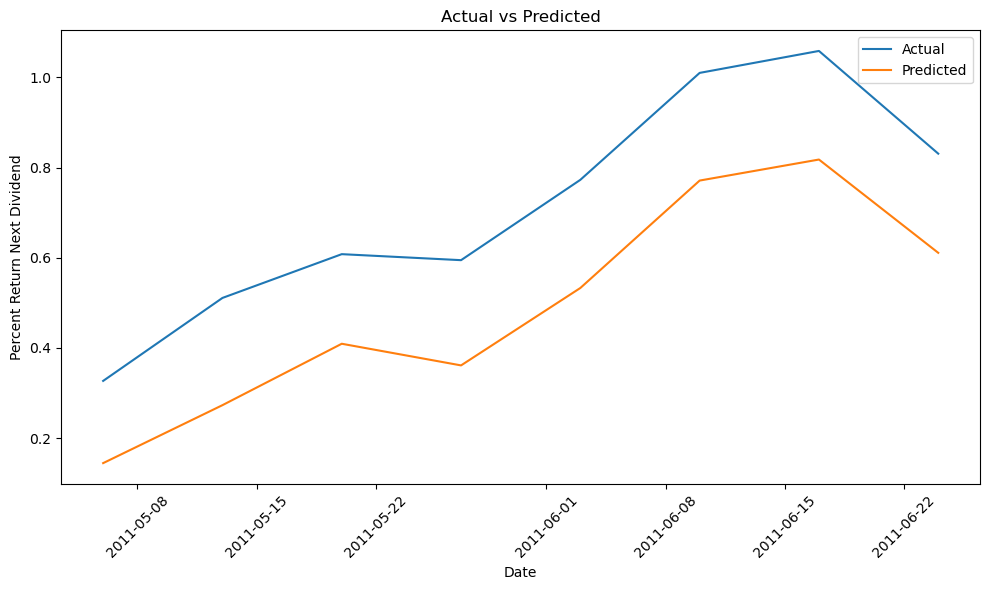

In [315]:
# Reshape input to be 3D [samples, timesteps, features]
X_train_dt = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_dt = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


# Create and fit the GRU network with more layers
model = Sequential([
    GRU(16, input_shape=(X_train_dt.shape[1], X_train_dt.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# Train the model
model.fit(X_train_dt, y_train, epochs=100, batch_size=1, verbose=1)

# Make predictions
predictions = model.predict(X_test_dt)

# Calculate root mean squared error
rmse = np.sqrt(np.mean((predictions.flatten() - y_test) ** 2))
print('RMSE:', rmse)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, predictions.flatten(), label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Percent Return Next Dividend')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


RMSE: 0.24813419447217563


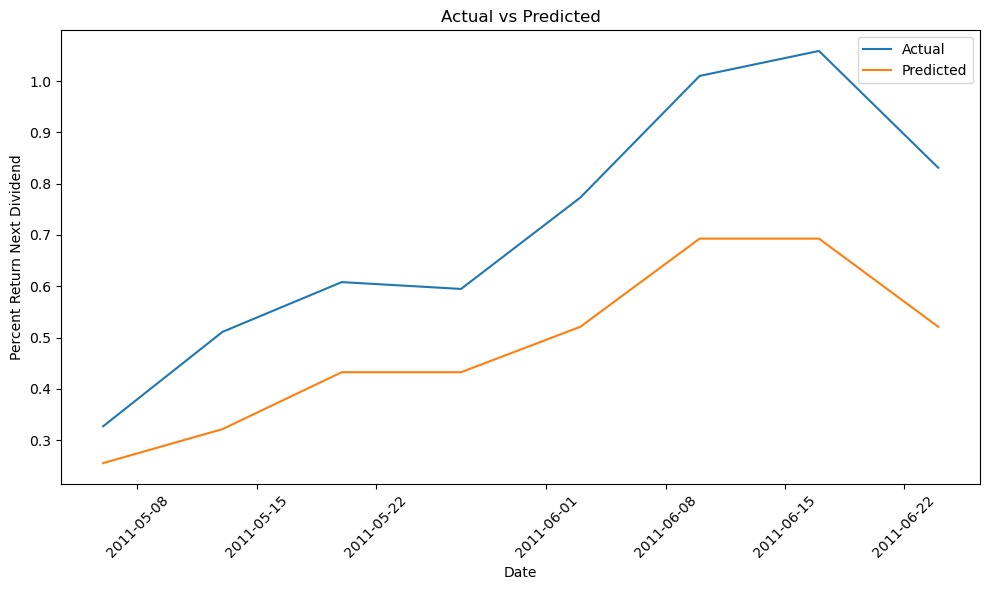

In [313]:
# Create and fit the XGBoost model
model = XGBRegressor(objective='reg:squarederror', learning_rate=0.01, n_estimators=100)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE:', rmse)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Percent Return Next Dividend')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


00:16:23 - cmdstanpy - INFO - Chain [1] start processing


00:16:26 - cmdstanpy - INFO - Chain [1] done processing


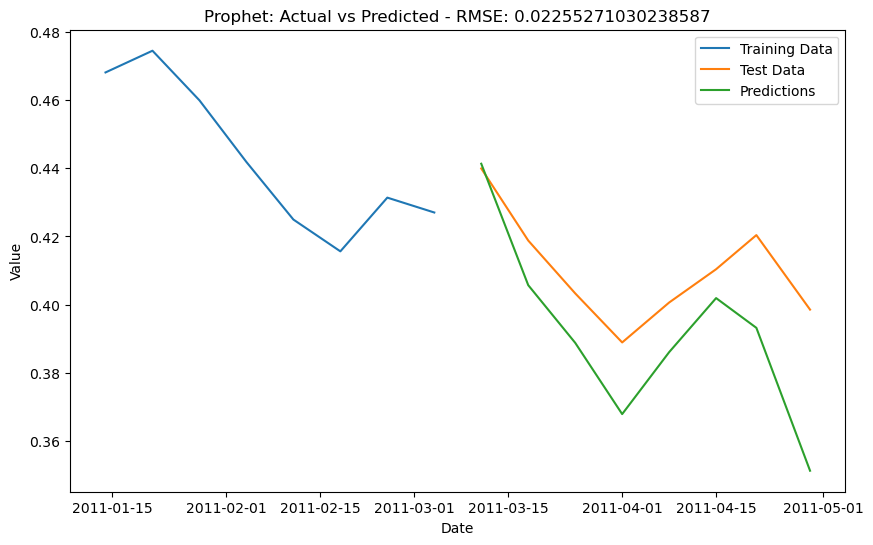

00:16:27 - cmdstanpy - INFO - Chain [1] start processing
00:16:27 - cmdstanpy - INFO - Chain [1] done processing


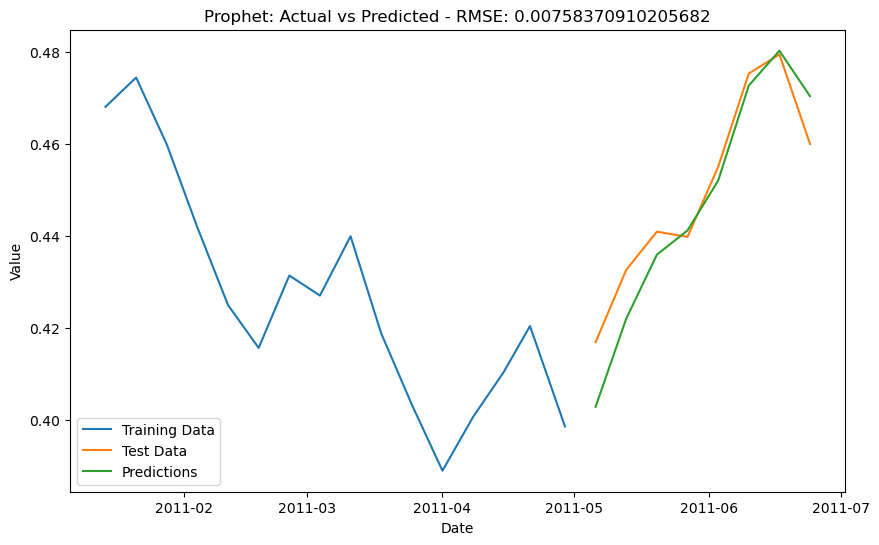

In [164]:
# Load the dataframe
datadf = {
    "date": ["2011-01-14", "2011-01-21", "2011-01-28", "2011-02-04", "2011-02-11", "2011-02-18", "2011-02-25", "2011-03-04", "2011-03-11", "2011-03-18", "2011-03-25", "2011-04-01", "2011-04-08", "2011-04-15", "2011-04-21", "2011-04-29", "2011-05-06", "2011-05-13", "2011-05-20", "2011-05-27", "2011-06-03", "2011-06-10", "2011-06-17", "2011-06-24"],
    "close": [94.01, 92.75, 95.68, 99.59, 103.54, 105.86, 102, 103.04, 100.02, 105.06, 109.09, 113.12, 109.82, 107.21, 109.42, 115.41, 110.34, 106.33, 104.33, 104.6, 101.1, 96.79, 95.95, 100.01],
    "volume": [19707235, 28651009, 34929068, 31169285, 27632394, 16331886, 28146727, 29851515, 38614049, 54195667, 37837456, 28116391, 28772937, 30697889, 23938892, 34522949, 39678464, 38211403, 54274252, 30213720, 35887587, 40431926, 43606429, 43722864],
    "percent_change_price": [0.858277, -1.49745, 3.20354, 3.59929, 3.93495, 2.22093, -2.72745, 0.311526, -3.28757, 2.40764, 2.04864, 3.26821, -3.45495, -2.55408, 3.63705, 5.64811, -5.07571, -4.0343, -1.45461, 3.25765, -4.99013, -3.45137, -1.01104, 3.64805],
    "percent_change_volume_over_last_wk": [-18.34888, 45.383201, 21.912174, -10.764052, -11.34736, -40.89587, 72.342172, 6.056789, 29.353733, 40.352199, -30.183614, -25.691645, 2.335101, 6.690148, -22.017791, 44.212811, 14.933588, -3.697373, 42.036795, -44.331393, 18.779108, 12.662704, 7.851476, 0.267013],
    "percent_return_next_dividend": [0.468035, 0.474394, 0.459866, 0.441811, 0.424957, 0.415643, 0.431373, 0.427019, 0.439912, 0.418808, 0.403337, 0.388967, 0.400656, 0.410409, 0.420398, 0.398579, 0.416893, 0.432615, 0.440909, 0.439771, 0.454995, 0.475256, 0.479416, 0.459954]
}


# Convert to DataFrame
df = pd.DataFrame(analysed_stock_data)

# Convert date column to datetime
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['percent_return_next_dividend'] 
df = df[['ds','y','close','volume','percent_change_price','percent_change_volume_over_last_wk']]
# Create TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)

# Iterate through each split and fit the model
for train_index, test_index in tscv.split(df):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]
    
    # Fit the model
    model = Prophet()
    model.add_regressor('close')
    model.add_regressor('volume')
    model.add_regressor('percent_change_price')
    model.add_regressor('percent_change_volume_over_last_wk')
    model.fit(train_df)
    
    forecast = model.predict(test_df.drop(columns="y"))

        
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.plot(train_df['ds'], train_df['y'], label='Training Data')
    plt.plot(test_df['ds'], test_df['y'], label='Test Data')
    plt.plot(test_df['ds'], forecast[-len(test_df):]['yhat'], label='Predictions')
    rmse_prophet = np.sqrt(mean_squared_error(df.iloc[test_index]['y'],forecast[-len(test_df):]['yhat']))
    plt.title(f'Prophet: Actual vs Predicted - RMSE: {rmse_prophet}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()



#### Analysis of Time Series Prediction using the CAT data and a stock which data is very correlated with CAT data, VZ stock.

In [317]:
# Then, we get the most five correlated stocks with CAT
correlated_stock = get_top_correlated_stocks(correlation_results_stocks,'CAT',1)[0]
correlated_stock

'VZ'

In [318]:
analysed_stock_df = data[data['stock'] == stock][['date', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'percent_return_next_dividend']]
correlated_stock_df = data[data['stock'] == correlated_stock][['close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume']]
for c in ['close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume']:
    analysed_stock_df['c_' + c] = correlated_stock_df[c].values


04:53:35 - cmdstanpy - INFO - Chain [1] start processing
04:53:35 - cmdstanpy - INFO - Chain [1] done processing


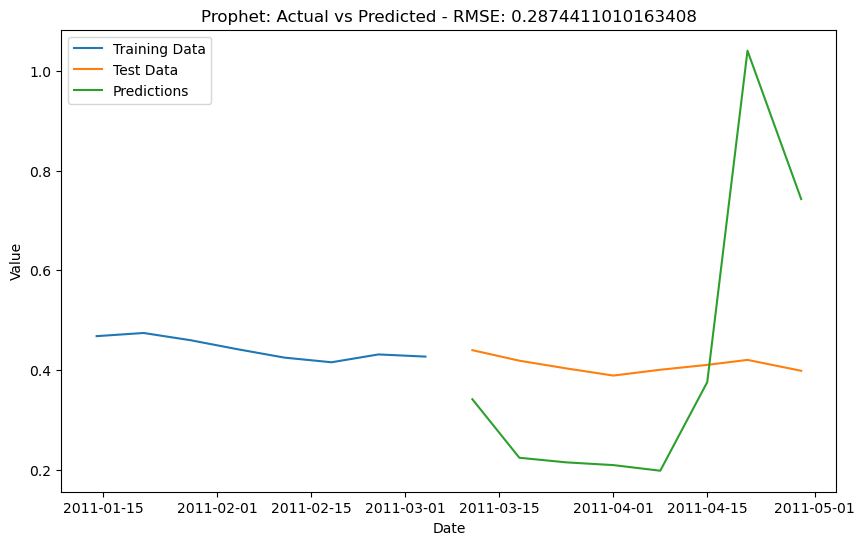

04:53:36 - cmdstanpy - INFO - Chain [1] start processing
04:53:44 - cmdstanpy - INFO - Chain [1] done processing


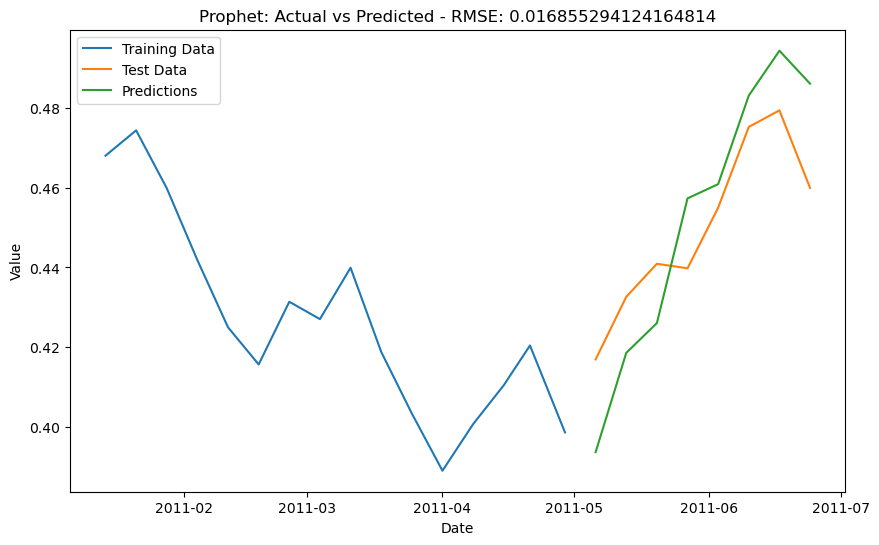

In [319]:
# Convert to DataFrame
df = pd.DataFrame(analysed_stock_df)

# Convert date column to datetime
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['percent_return_next_dividend'] 
df = df[['ds','y','close','volume','percent_change_price','percent_change_volume_over_last_wk','c_close','c_volume','c_percent_change_price','c_percent_change_volume_over_last_wk']]
# Create TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)

# Iterate through each split and fit the model
for train_index, test_index in tscv.split(df):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]
    
    # Fit the model
    model = Prophet()
    model.add_regressor('close')
    model.add_regressor('c_close')
    model.add_regressor('volume')
    model.add_regressor('c_volume')
    model.add_regressor('c_percent_change_price')
    model.add_regressor('percent_change_price')
    model.add_regressor('c_percent_change_volume_over_last_wk')
    model.add_regressor('percent_change_volume_over_last_wk')
    model.fit(train_df)
    
    forecast = model.predict(test_df.drop(columns="y"))

        
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.plot(train_df['ds'], train_df['y'], label='Training Data')
    plt.plot(test_df['ds'], test_df['y'], label='Test Data')
    plt.plot(test_df['ds'], forecast[-len(test_df):]['yhat'], label='Predictions')
    rmse_prophet = np.sqrt(mean_squared_error(df.iloc[test_index]['y'],forecast[-len(test_df):]['yhat']))
    plt.title(f'Prophet: Actual vs Predicted - RMSE: {rmse_prophet}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()



-----
*Add here your modelling results and conclusions (max. 200 words)*

In the modeling phase, three different models were trained: GRU, XGBoost, and Prophet. Although XGBoost is not a time series model, it was chosen because of its ability to extract insights from sequential data. Since this is a regression-based problem, the evaluation metric used was root mean square error (RMSE). The scale of RMSE matches that of the predicted variable, making it directly interpretable and comparable to the original data.The train/test split was set at a 70%/30% ratio.

Initially, the 'CAT' stock was chosen as the target stock, with the target parameter being 'percent_return_next_dividend'. The best predictors of the target parameter (feature selection), including close, volume, percent_change_price, percent_change_volume_over_last_wk, and previous_weeks_volume, were analyzed. Due to some price parameters having similar correlation values, I decided to select the most correlated parameter, which was the close price parameter. Among the models, Prophet achieved the lowest RMSE (0.00758), followed by GRU (0.22) and XGBoost (0.24).

In a subsequent phase, the most correlated stock with the analyzed stock was examined, and the impact of adding its input data was assessed. It was observed that adding input data from correlated stocks did not improve model performance; in fact, it did not lower the RMSE (0.016 > 0.00758) in this case.

-----

## Conclusions
In the conclusions, you should enumerate the results you got after completing the challenge.
* How good do you consider your results? 
* What are some factors that would contribute to get better results?
* What are some advantages and disadvantages of your solution?
* What can be done as future work to improve your results?


-----
I am not confident in the results of my trained models. Based on my experience, I've found that using a multivariate input for prediction often yields better results, although I could have analyzed univariate-based prediction methods more thoroughly. A deeper understanding of how correlated stock data can enhance model predictions would be invaluable. The error rate from the XGBoost model exceeded my expectations, leaving me somewhat perplexed. Despite the GRU's reputation for excelling with smaller datasets, its performance fell short of the mark.

My proposed solution has the advantage of being a sophisticated multivariate time series model adept at extracting insights from diverse parameters over time. Moving forward, I plan to delve into outlier analysis and develop predictive models for forecasting other mentioned target parameters. Although hyperparameter fine-tuning remains unimplemented for now, it's a strategy I intend to integrate in future iterations.

-----

#### Feedback

-----
*Add here your thoughts and feedback regarding this challenge.*

I thought this work would be simple, but in reality, in my effort to find the most correlated stocks and assess their impact on the models' predictions, I lost track of time.

-----

To submit your solution you should e-mail us this notebook in response to the e-mail you initially received with the challenge.